In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
n_rows = 7
n_cols = 10
gridworld = np.zeros((n_rows, n_cols))

In [4]:
init_pos = np.array([3, 0])
goal_pos = np.array([3, 7])

In [5]:
strength = -np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])
wind = np.c_[strength, np.zeros(n_cols)]
wind = np.zeros((n_rows, n_cols, 2)) + wind[None, ...]

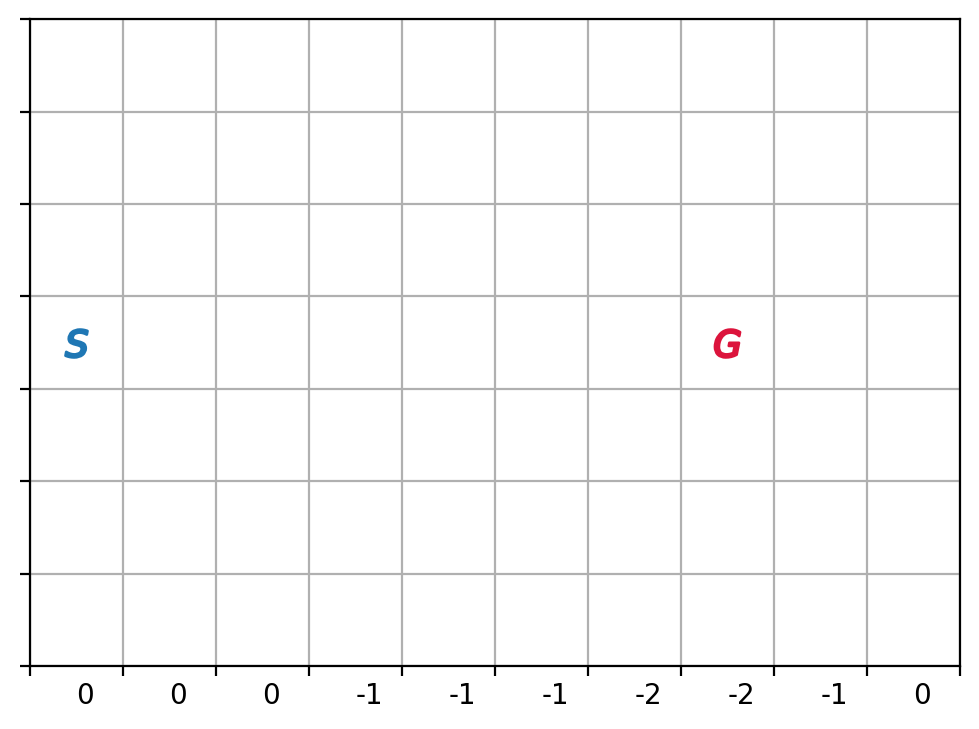

In [6]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.6))
xticks = np.arange(n_cols + 1)
yticks = np.arange(n_rows + 1)

init = init_pos[::-1] + 0.5
goal = goal_pos[::-1] + 0.5
ax.scatter(*init, marker="$S$", s=100)
ax.scatter(*goal, marker="$G$", s =100, c="crimson")
# plt.scatter(*finish_pos)

ax.set_xticks(xticks, labels="")
plt.yticks(yticks, labels="")

# TODO: change for minor xticks
for x, s in enumerate(strength):
    plt.text(x + 0.5, -0.4, s)

plt.grid()

In [7]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # up,
    [-1, 0], # down
])
n_actions = len(movements)

In [22]:
@njit
def get_probas(qval, epsilon):
    qmax = qval.max()
    n_actions = len(qval)
    mask = qmax == qval

    if np.all(mask):
        probas = np.ones(n_actions) / n_actions
    elif sum(mask) > 1:
        n_equal = sum(mask)
        probas = epsilon * np.ones(n_actions) /  n_actions
        probas = ((1 - epsilon) / n_actions + epsilon) * mask +  probas * (1 - mask)
    else:
        # return epsilon-greeedy action
        action_max = qval.argmax()
        probas = epsilon * np.ones(n_actions) / n_actions
        probas[action_max] = 1 - epsilon + epsilon / n_actions

    return probas

## Another gridworld

In [23]:
n_rows = 7
n_cols = 10
ixs = np.arange(n_rows * n_cols).reshape(n_rows, n_cols)
ixs

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]])

In [73]:
# @njit
def get_pos(ix, n_cols):
    col = ix // n_cols
    row = ix % n_cols
    pos = np.array([col, row])
    return pos


# @njit
def get_ix(pos, n_cols):
    row, col = pos
    ix = row * n_cols + col
    return ix


# @njit
def move_pos(pos, step, n_row, n_cols):
    row, col = pos
    row_next, col_next = pos + step
    
    if (row_next < 0) or (row_next >= n_rows):
        row_next = row
    if (col_next < 0) or (col_next >= n_cols):
        col_next = col
    
    pos_next = np.array([row_next, col_next])
    return pos_next


# @njit
def move(ix, step, n_rows, n_cols):
    pos = get_pos(ix, n_cols)
    pos_new = move_pos(pos, step, n_rows, n_cols)
    ix_new = get_ix(pos_new, n_cols)
    return ix_new


# @njit
def move_and_reward(ix, step, n_rows, n_cols, end_state, reward_goal):
    ix_new = move(ix, step, n_rows, n_cols) # new s
    reward = -1 if ix_new != end_state else reward_goal
    ix_new = ix_new if ix_new != end_state else 30
    return ix_new, reward

# @njit
def choose_action(ix, Q, epsilon):
    probas = get_probas(Q[ix], epsilon)
    action = np.random.multinomial(1, probas).argmax()
    return action

# @njit
def sarsa_step(s, a, Q, epsilon, n_rows, n_cols, end_state, reward_goal):
    # (s, a) -> (r, s_new, a_new)
    step = movements[action]
    s_new, r = move_and_reward(s, step, n_rows, n_cols, end_state, reward_goal)
    a_new = choose_action(s_new, Q, epsilon)

    return r, s_new, a_new

In [74]:
Q = np.zeros((n_rows * n_cols, n_actions)) # action-value function
Q.shape

(70, 4)

In [75]:
epsilon = 0.005
alpha = 0.5
gamma = 1.0
ix = 30
end_state =  69#37
action = choose_action(ix, Q, epsilon)

ix_hist = [30]
reward_hist = [0]
reward_goal = 10

for _ in range(20_000):
    r, ix_new, action_new = sarsa_step(ix, action, Q, epsilon, n_rows, n_cols, end_state, reward_goal)
    Q[ix, action] = Q[ix, action] + alpha * (r + gamma * Q[ix_new, action_new] - Q[ix, action])
    ix, action = ix_new, action_new
    ix_hist.append(ix)
    reward_hist.append(r)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

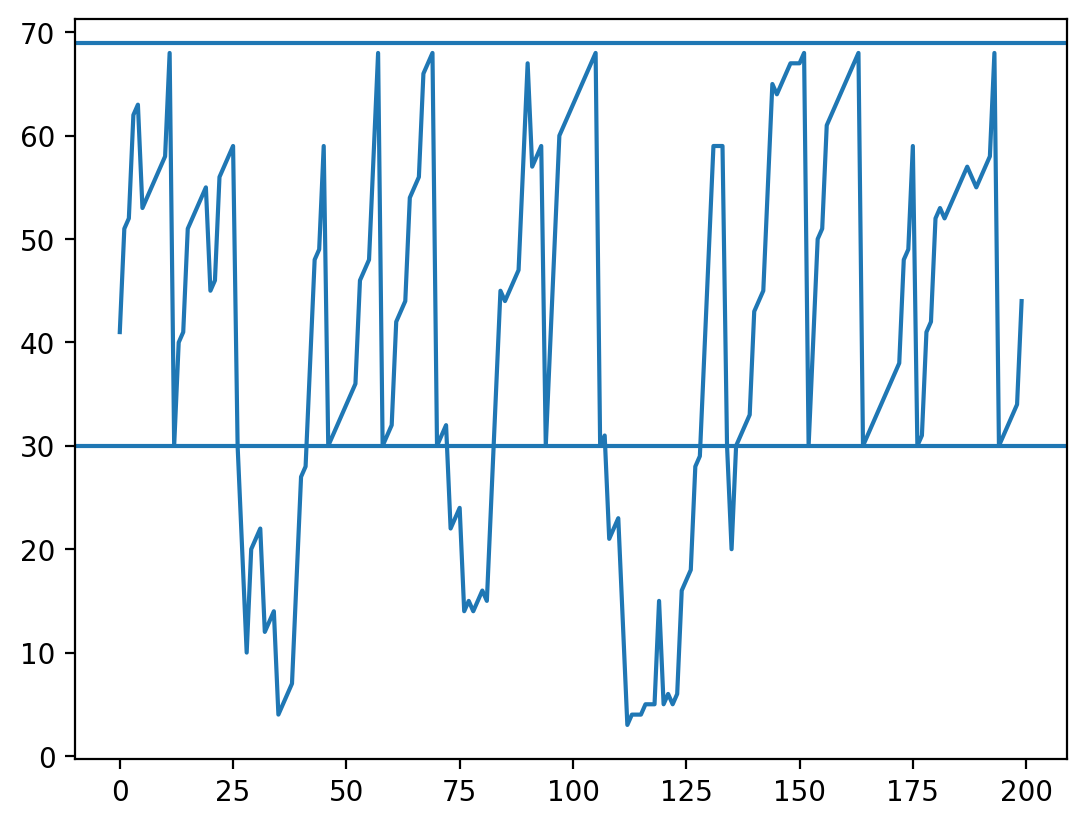

In [76]:
plt.plot(ix_hist[-200:])
plt.axhline(y=end_state)
plt.axhline(y=30)

In [77]:
ix_hist[-100:]

array([63, 64, 65, 66, 67, 68, 30, 31, 21, 22, 23, 13,  3,  4,  4,  4,  5,
        5,  5, 15,  5,  6,  5,  6, 16, 17, 18, 28, 29, 39, 49, 59, 59, 59,
       30, 20, 30, 31, 32, 33, 43, 44, 45, 55, 65, 64, 65, 66, 67, 67, 67,
       68, 30, 40, 50, 51, 61, 62, 63, 64, 65, 66, 67, 68, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 48, 49, 59, 30, 31, 41, 42, 52, 53, 52, 53, 54,
       55, 56, 57, 56, 55, 56, 57, 58, 68, 30, 31, 32, 33, 34, 44])

In [78]:
reward_hist[-100:]

array([-1, -1, -1, -1, -1, -1, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, 10, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 10, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, 10, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, 10, -1, -1, -1, -1, -1])

In [79]:
(reward_hist == reward_goal).sum()

1218

In [80]:
np.diff(np.where(reward_hist == reward_goal)[0]).mean()

16.235004108463436

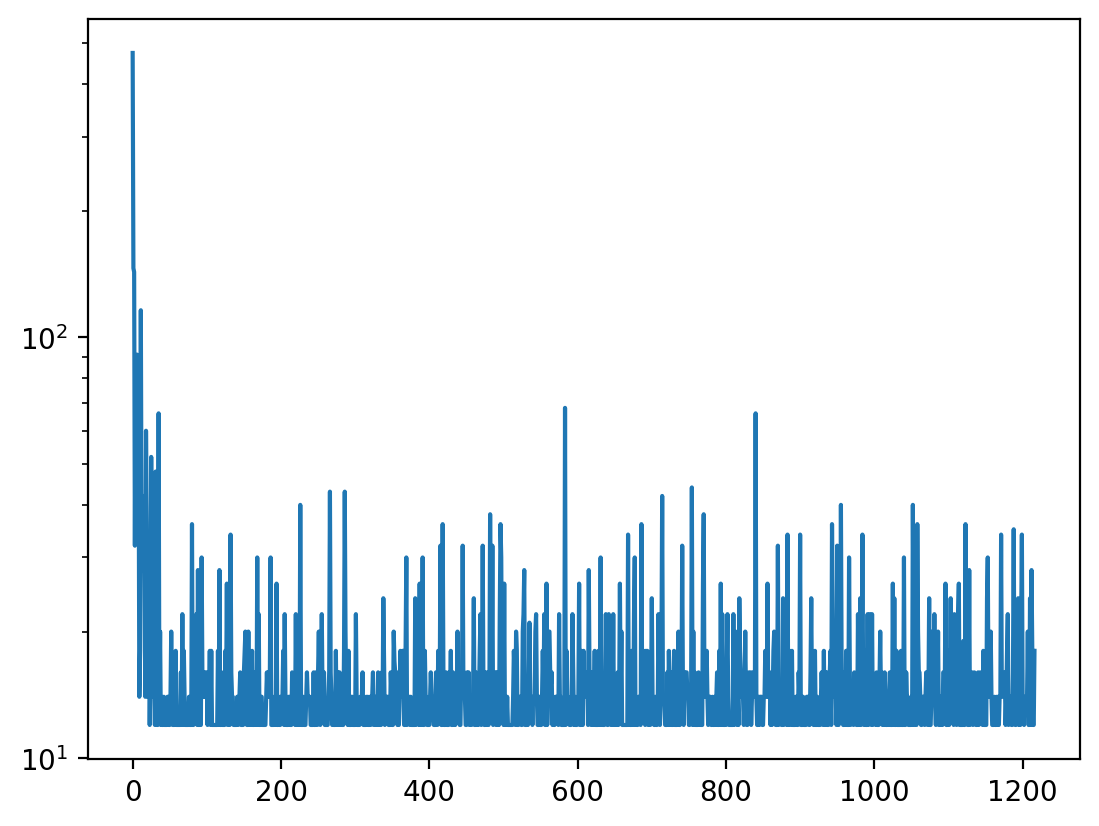

In [83]:
plt.plot(np.diff(np.where(reward_hist == reward_goal)[0]))
plt.yscale("log")

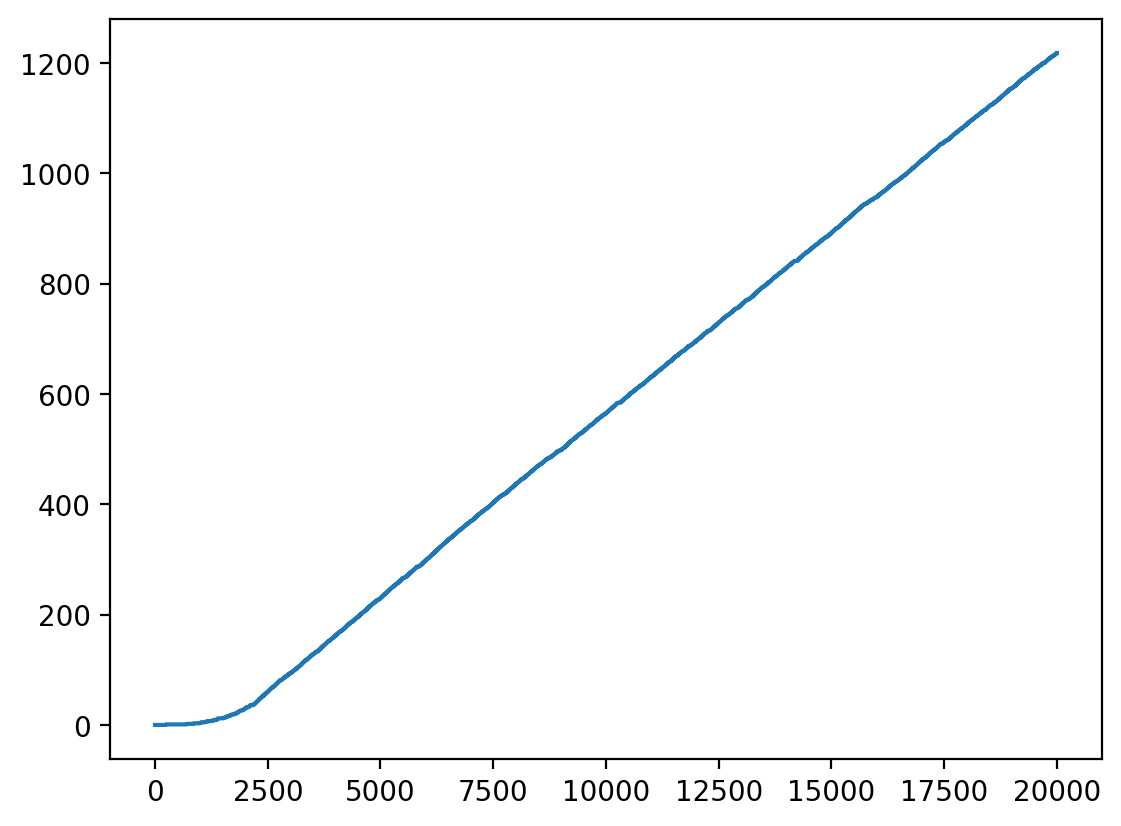

In [82]:
plt.plot((reward_hist == reward_goal).cumsum())